# A) Semantic Segmentation



### Question

a. What does the segmentation map represent? 

b. How can we convert a classification network to a segmentation prediction network? 

c. How to implement a decoder network? 

d. What is a possible issue with transposed deconvolution? How can we overcome this issue? 

e. What is the main problem with encoding/decoding architectures in general? 



**Answer**:

### Question

There are different interpolation types to upsample an image, such as nearest, linear, bilinear, bicubic... In this question, an original size baboon image, and a downsampled baboon image is provided. Interpolate the downsampled image with different modes, visualize them.

Typically, PSNR and SSIM metrics are used to evaluate the quality of a compressed/decompressed image. We can use them to measure the interpolation quality. 


**Answer**:

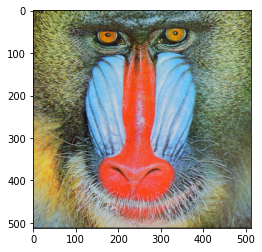

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

img = cv2.imread('baboon.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

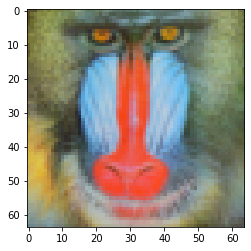

In [9]:
from skimage import data, color, img_as_float
from skimage.transform import rescale, resize

img = img_as_float(img)
image_resized = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

plt.imshow(image_resized)

In [10]:
import torch
import torch.nn

img_tensor = torch.from_numpy(image_resized.transpose(2,0,1)).unsqueeze(0)

# TODO: Use interpolation function torch.nn.functional to upsample images with different modes.
img_nearest =
img_bilinear = 
img_bicubic = 

# TODO: Convert images back to numpy. 
img_nearest = 
img_bilinear = 
img_bicubic = 

In [ ]:
# Visualization of images
f, axarr = plt.subplots(1,4,figsize=(20,20))
axarr[0].imshow(img)
axarr[1].imshow(img_nearest)
axarr[2].imshow(img_bilinear)
axarr[3].imshow(img_bicubic)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# TODO: calculate the psnr and ssim scores between original image and upsampled
# version. Do these scores align with the visualizations?



# B) Fully Convolutional Network for Semantic Segmentation

In this exercise, we will implement a neural network for semantic segmentation, and train and test the results with the provided dataset. As it would take a long time to train the whole network, we'll finetune the model by reusing a pretrained backbone model (eg. VGG16). You can influence from FCN, which is one of the first architectures proposed for semantic segmentation[1](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). 

We provide a skeleton code which should be filled in respectively. The dataloaders and utilization codes are also provided. 

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">





## MSRC-v2 Segmentation Dataset


We'll use the MSRC dataset for this exercise, which contains 591 images and 23 different semantic labels. The training is done on 276 images, validation on 59 and testing on 275 images. More info about the labels can be found on "info.html". 

To get the dataset, either run the download.sh and upload the data into the notebook, or run the commands below to directly get them into the notebook.

In [ ]:
# Get segmentation dataset
!wget http://filecremers3.informatik.tu-muenchen.de/~dl4cv/segmentation_data.zip
!unzip segmentation_data.zip
!rm segmentation_data.zip

# Get segmentation dataset test
!wget http://filecremers3.informatik.tu-muenchen.de/~dl4cv/segmentation_data_test.zip
!unzip segmentation_data_test.zip
!rm segmentation_data_test.zip

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from segmentation_nn import SegmentationNN
from data_utils import SegmentationData, label_img_to_rgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
train_data = SegmentationData(image_paths_file='segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file='segmentation_data/val.txt')

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


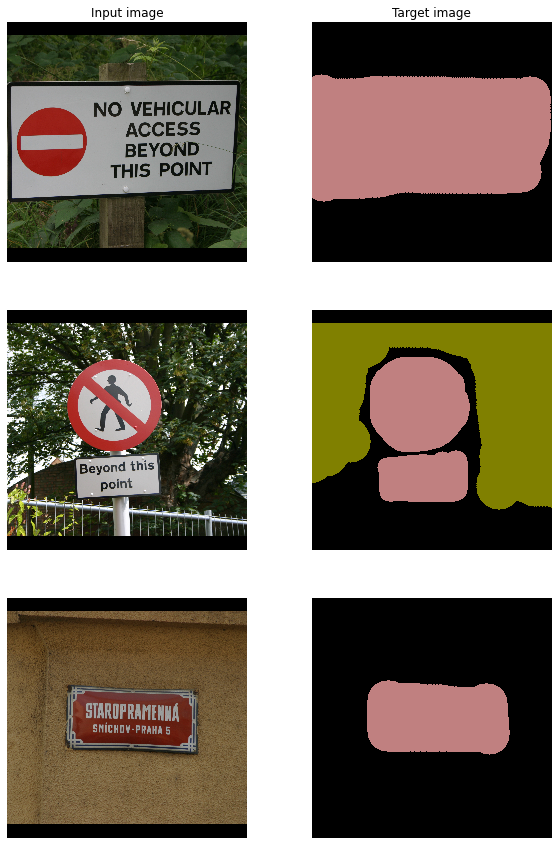

In [56]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

## Part 1: Implement and Train the Network:## 

Let's implement the neural network by filling up the necessary parts in `segmentation_nn.py`. It will take an input of size (N, C, H, W) and output (N, num_classes, H, W). As a pretrained backbone, you can use the VGG16 network from torchvision library, or any other backbone you wish. Start with a simple model where you take the feature layer from VGG, and introduce several layers which end up with segmentation predictions (FCN32 might be an example).

For training, we provide the skeleton `solver.py` code. Fill in the given code for training and evaluation. The dataloaders are already provided, and you need to code up the stochastic gradient descent by using pytorch functions. As for the loss, we can go with the typical `CrossEntropyLoss`. Note that there are some `unlabeled` classes in the dataset. These pixels should not be considered in the loss nor in the accuracy of the segmentation.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

## This is provided for debugging! After implementing the network, put it into
## the "segmentation_nn.py" file. 

class FCN(nn.Module):

    def __init__(self, num_classes=23):
        super(FCN, self).__init__()

        model = models.vgg16(pretrained= True)

    def forward(self, x):
      pass

In [57]:
from segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F


########################################################################
#                             YOUR CODE                                #
########################################################################
# Tip: You can freeze the backbone
# Tip: Try overfitting the network first, for a single sample.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True, num_workers=4)

model = SegmentationNN().cuda()

solver = Solver()

epoch = 10
model = solver.train(model, train_loader, val_loader, epoch, log_nth = 10)

In [ ]:
# Save the model

model.save("segmentation_nn.pth")

## Part 2: Test the Model

Your model should result with a pixel accuracy of more than 60%.

In [ ]:
test_data = SegmentationData(image_paths_file='segmentation_data_test/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

test_scores = []
total_ious = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    ## TODO: Retrieve the predictions
    

    ## TODO: Calculate the test scores (mean accuracy of correctly classified labels).
    
    
    ## TODO: Later on, after implementing the IoU, calculate and report it. 
    

print("Test accuracy: ", np.mean(test_scores))
print("Test IoU: ", np.nanmean(total_ious))

## Part 3: Visualize the Results

Your model should result with a pixel accuracy of more than 60%.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


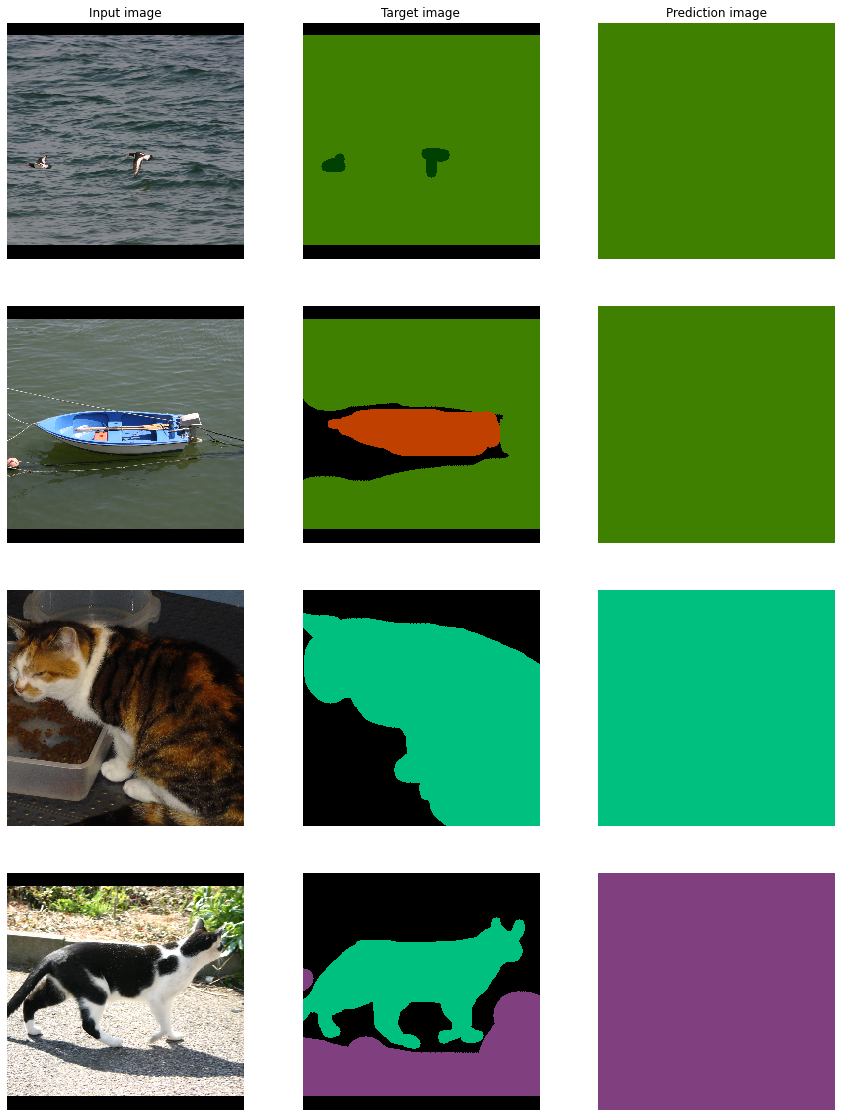

In [61]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    ## TODO: Retrieve the predictions.

    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

## Part 4: Visualize Filter Weights
You can visualize the convolutional filters of the very first layer. Each kernel provides the structures of edges, corners and circles. 


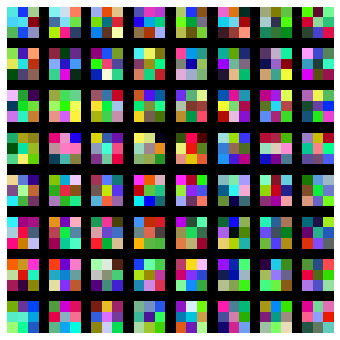

In [10]:
from vis_utils import visualize_grid

# TODO: get the first (next) convolutional parameter 
conv_params = 
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

## Part 5: Segmentation IoU

Implement the Intersection over Union segmentation metric, and measure the segmentation accuracy for the trained model. 



In [50]:
n_class = 23
def iou(pred, target):
    ious = []
    for cls in range(0, n_class):
        ## TODO: Calculate intersection and union for each class
      
        if union == 0: # if there is no ground truth, do not include in evaluation
            pass
        else:
            pass
    return np.nanmean(ious)

# C) Better Architectures

**Question 1:** Actually, FCN was introduced in 2015, so it's a pretty old architecture. As you have seen in the lecture, there are better models such as SegNet or UNet. Why does U-Net work better than FCN or SegNet? 


**Answer**: 

**Question 2:** What are some ways to help networks learn scale-wise rich context? Explain how they work, and compare the advantages/disadvantages. 

**Answer**: 

**Question 3:** How can we enforce the model to focus on creating better edges? Give solutions in terms of (1) loss function, (2) refinement method, (3), network architecture. 


**Answer**:

**Question 4:** How can we deal with the unbalanced data? Can you name a loss function from the previous lectures that might help for that?


**Answer**: 

**Question 5: Improve your model!** 

By following these ideas, try to improve your previously trained model. You can think about modifying the network, backbone architecture, loss function, adding extra modules, data augmentation, hyperparameter optimization. 

Try at least 2 different things and report the results in the class! What have you tried, did it improve the accuracy and IoU? 

**Answer**:

### References
[1] J. Long, E. Shelhamer, and T. Darrell. Fully Convolutional Networks for Semantic Segmentation. CVPR, 2015.

[2] V. Badrinarayanan, A. Kendall, and R. Cipolla. Fully Convolutional Networks for Semantic Segmentation. PAMI, 2017.

[3] O. Ronneberger, P. Fischer, and T. Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. MICCAI, 2015.

[4] Checkerboard artifacts [https://distill.pub/2016/deconv-checkerboard/]

[5] A survey of loss functions for semantic segmentation [https://arxiv.org/pdf/2006.14822.pdf].

